Load Libraries

In [1]:
from main import char_list_from_file,infer_single
from model import Model,DecoderType
import cv2
from matplotlib import pyplot as plt
import numpy as np
from segmentation import get_segments
from imutils.perspective import four_point_transform
from postprocessing import postProcess
currentModel=None


Load The Model

In [2]:
##Initialize Model
##1st Argument is the list of character
##2nd Argument Specifies CTC Decoder Type
##3rd Argument If True Load The Existing Model From models/snapshot-**
if currentModel==None:
    print("Loading Model")
    currentModel = Model(char_list_from_file(), DecoderType.BestPath,must_restore=True)
else:
    print("Model Already Loaded")



Loading Model


c:\Users\USER\Desktop\clgproject\src\model.py:73: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  conv_norm = tf.compat.v1.layers.batch_normalization(conv, training=self.is_train)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\legacy_tf_layers\normalization.py:463: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs, training=training)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


c:\Users\USER\Desktop\clgproject\src\model.py:86: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cells = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_hidden, state_is_tuple=True) for _ in
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(


Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Tensorflow: 2.8.0
Init with stored values from ../model/snapshot-13
INFO:tensorflow:Restoring parameters from ../model/snapshot-13


Load Image

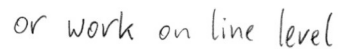

In [3]:
path='C:\\Users\\USER\\Desktop\\clgproject\\src\\uploads\\line.png'
original_image=cv2.imread(path)

plt.imshow(original_image)
plt.axis('off')
plt.show()

Segment The Line Into Words

5


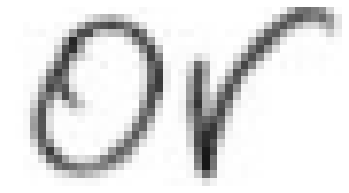

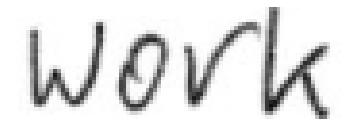

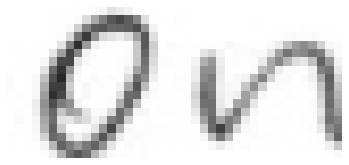

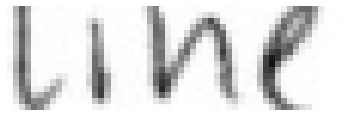

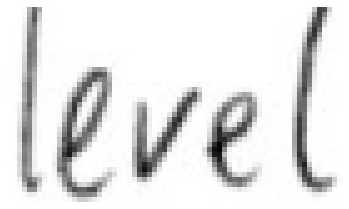

In [4]:
word_images=get_segments(path)

# create an array of random images

print(len(word_images))
# display each image in a loop
for img in word_images:
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)


Skew Correction

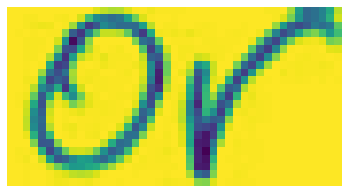

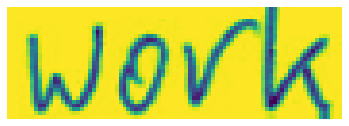

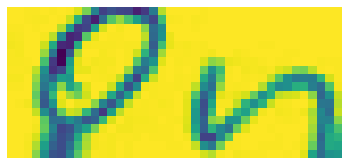

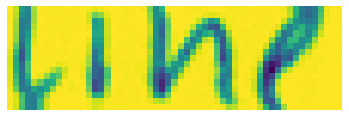

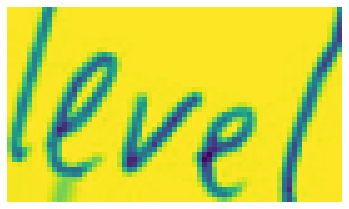

In [5]:
from skew import skewCorrect
for i in range(len(word_images)):
    
    word_images[i]=skewCorrect(word_images[i])
    plt.figure()
    plt.axis('off')
    plt.imshow(word_images[i])



Binarize The Image Using OTSU's Method

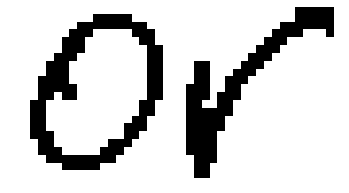

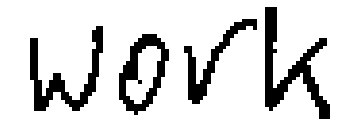

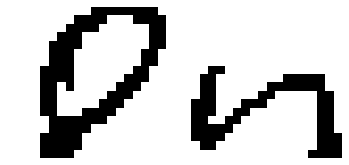

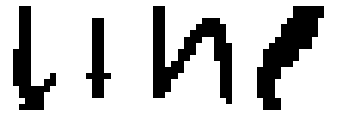

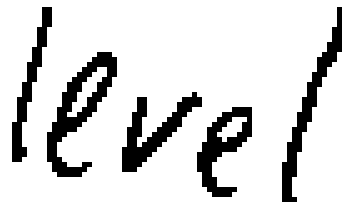

In [6]:
for i in range(len(word_images)):
    img=word_images[i]
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh=cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)
    word_images[i]=thresh
    plt.figure()
    plt.axis('off')
    plt.imshow(thresh)

Skew Correction Using Canny

In [7]:
for img in word_images:
    # Load the image
    

    # Convert to grayscale
    ##gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(img, 50, 150, apertureSize=3)

    # Apply Hough line transform to detect lines
    lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=100)

    # Calculate the angle of the rotation
    angle = 0.0
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            angle += np.arctan2(y2-y1, x2-x1)

        angle /= len(lines)
        angle *= 180 / np.pi

        # Rotate the image
        rows, cols = img.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        rotated_img = cv2.warpAffine(img, M, (cols, rows), flags=cv2.INTER_CUBIC)
        plt.figure()
        plt.axis('off')
        plt.imshow(rotated_img)
    else:
        print("Couldn't Find Any Lines")

Couldn't Find Any Lines
Couldn't Find Any Lines
Couldn't Find Any Lines
Couldn't Find Any Lines
Couldn't Find Any Lines


Predict The Words Using Model

In [14]:
predicted_text=[]
probabilities=[]
for img in word_images:
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    currentPredicted=infer_single(currentModel,img)
    predicted_text.extend(currentPredicted[0])
    probabilities.extend(currentPredicted[1])
print("Recognized Text")
for i in range(len(predicted_text)):
    print(predicted_text[i],probabilities[i],sep="  ->   ")
    

Recognized Text
or  ->   0.8066553
work  ->   0.9216077
an  ->   0.17482895
ithe  ->   0.35225374
level  ->   0.9657685


Using PyEnchant Post Processing

In [15]:
print("Applying PyEnchant")
for word in predicted_text:
    postProcessedWord=postProcess(word)
    print(word,postProcessedWord,sep=" -> ")

Applying PyEnchant
or -> or
work -> work
an -> an
ithe -> the
level -> level
